In [1]:
import pandas as pd
import os
from IPython.display import display,HTML
from ipywidgets import IntProgress

sh_datapath = '/home/liusida/ipython/fund_scanner/data/a_stock/XSHG/'
sz_datapath = '/home/liusida/ipython/fund_scanner/data/a_stock/XSHE/'
pickle_path = '/home/liusida/ipython/fund_scanner/data/a_stock/multi_info_from_a_stock.pickle'

In [2]:
import numpy as np

df = pd.DataFrame([[1,2,'z'],[3,4,'d0'],[5,5,'dd']], columns=['a','b','t'])

def generate_derivatives(df):
    #找到所有数字列
    columns_is_numeric = [issubclass(np.dtype(d).type, np.number) for d in df.dtypes]
    df_numeric = df.loc[:, columns_is_numeric]

    #计算导数
    df_numeric = (df_numeric.shift(-1) - df_numeric) / df_numeric
    df_numeric.columns = ['d_'+c for c in df_numeric.columns]

    return df_numeric

#generate_derivatives(df)

In [3]:
def get_stock_name(df):
    name = str(df.loc[0,'股票名称'])
    code = df.loc[0,'股票代码'].replace('sh', '').replace('sz', '')
    return code + '\n' + name


In [4]:
df = pd.DataFrame([[1,2,'z'],[3,4,'d0'],[5,5,'dd']], columns=['a','b','t'])
df = generate_derivatives(df)

def series_set(df, name):
    series_set = {}
    for col in df.columns:
        s = df.loc[:,col]
        s.name = name
        series_set[col] = s
    return series_set

#series_set(df, 'test')


In [5]:
example_path = '/home/liusida/ipython/fund_scanner/data/a_stock/XSHE/sz002335.csv'

def file_to_series(filepath):
    df = pd.read_csv(filepath, encoding='GBK')
    stock_name = get_stock_name(df)
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    df = df.set_index('交易日期')
    df = df[df.index>pd.to_datetime('2014-1-1')]
    df = generate_derivatives(df)
    return series_set(df, stock_name)

#file_to_series(example_path)

In [6]:
def filelist(datapath):
    df_filelist = pd.DataFrame(os.listdir( datapath ))
    return df_filelist[df_filelist[0].str.endswith('.csv')][0].tolist()

#filelist( sz_datapath )

In [7]:
def read_all_data(path_list, max_stock_num=10000):
    df_set = {}
    read_stock_num = 0
    all_files = 0
    for path in path_list:
        all_files += len(filelist(path))
    pg_max = min(all_files, max_stock_num)
    pg = IntProgress(min=0,max=pg_max,value=0)
    display(pg)
    
    for path in path_list:
        for file in filelist( path ):
            if read_stock_num>max_stock_num-1:
                break
                
            ss = file_to_series(os.path.join(path, file))
            for key in ss.keys():
                name = ss[key].name
                if key not in df_set:
                    df_set[key] = pd.DataFrame(ss[key])
                else:
                    df_set[key] = pd.concat([df_set[key], ss[key]], axis=1)
                    
            read_stock_num += 1
            pg.value += 1
            pg.description = '%d/%d > %s'%(pg.value, pg_max, name)

    df_total = pd.DataFrame()
    for idx in df_set:
        if len(df_set[key].columns)==read_stock_num:
            df_total = pd.concat([df_total, df_set[idx]], axis=0)

    return df_total

#df = read_all_data([sh_datapath, sz_datapath], max_stock_num=10000)


In [8]:
#df.to_pickle(pickle_path)

# 读取后的分析从这里开始...

In [9]:
#df = pd.read_pickle(pickle_path)


In [12]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

def reduce_dim(result):
    m_pca = PCA(n_components=20)
    m_tsne = TSNE(n_components=2)
    result = m_pca.fit_transform(df.replace([np.inf, -np.inf], np.nan).fillna(-1).T)
    result = m_tsne.fit_transform(result)

    result = pd.DataFrame(result)
    result['name'] = df.columns

result = pd.read_pickle('/home/liusida/ipython/fund_scanner/packages/tmp/cache.tmp')


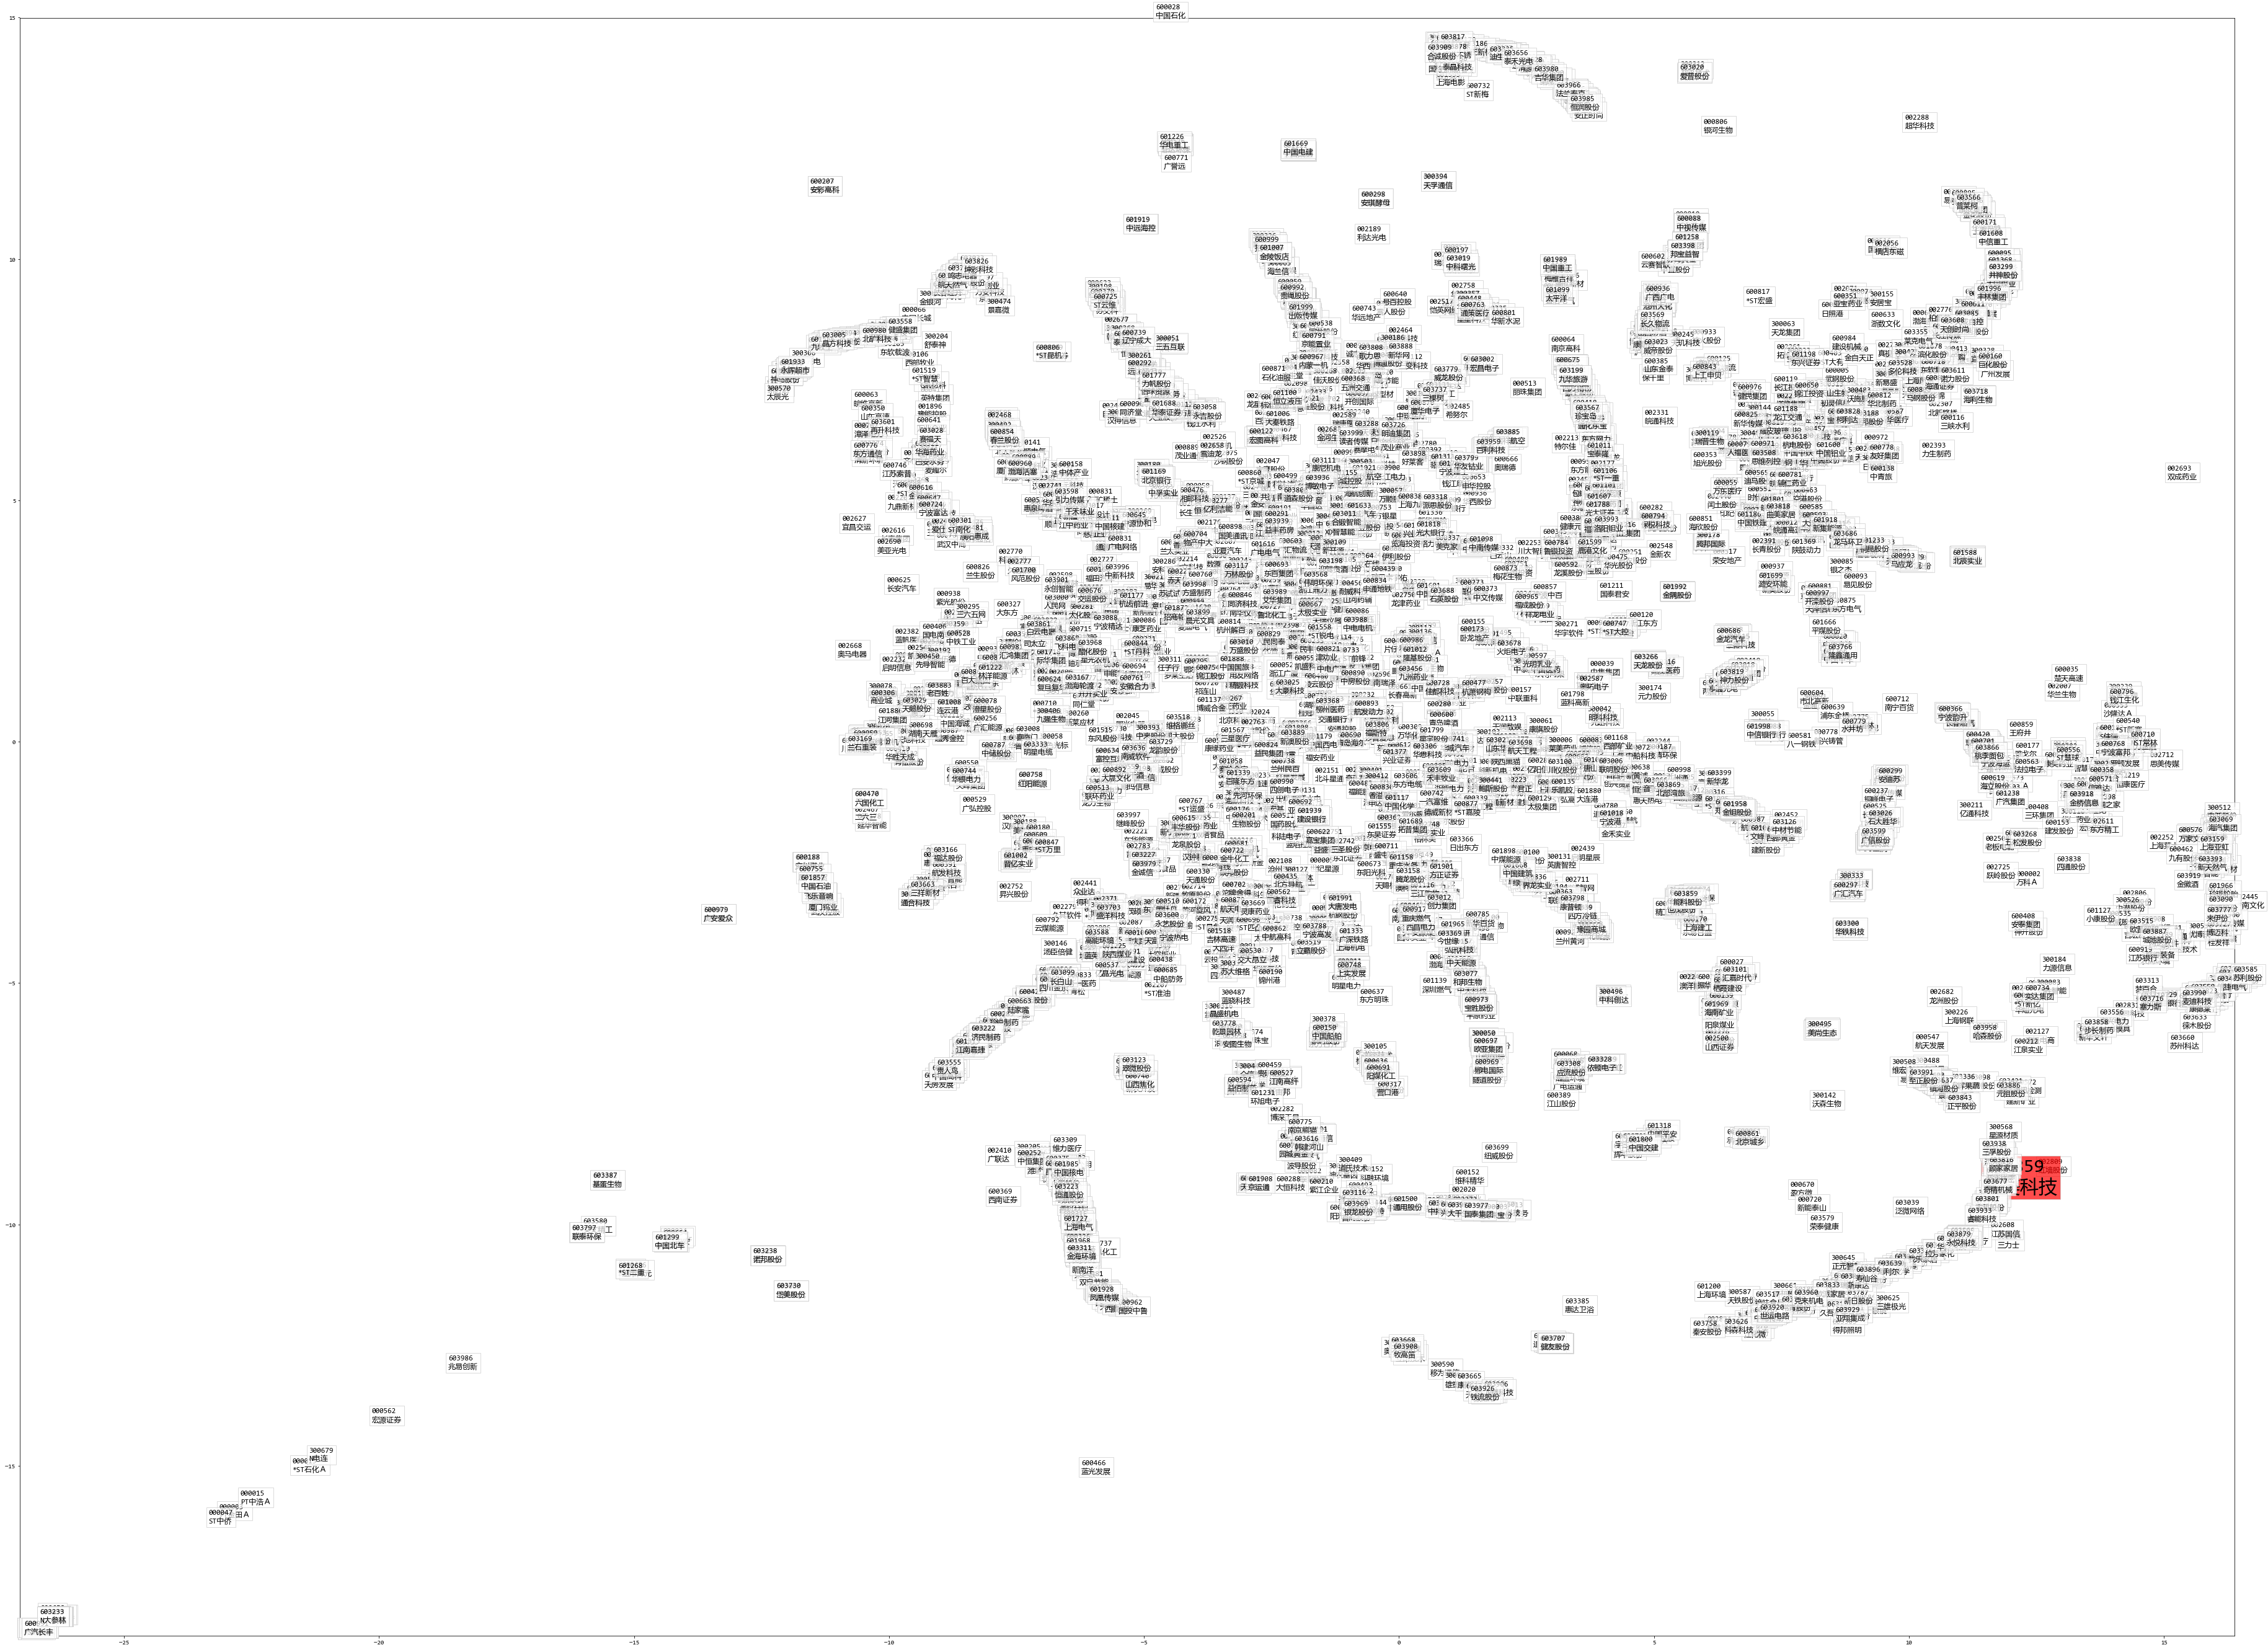

In [15]:
highlight = {
    #'red': ['002077','600604','600663','600895','600463','600648','600215','600658','600064','600848'],
    #'blue': ['300008', '600184', '300123', '600879', '600435', '300456', '600685', '002413', '300589', '600677', '300424', '601890', '000738', '601989', '000768', '002023', '002151', '600118', '300101', '002013', '600038', '600150', '600372', '600072', '600562', '600391', '600990', '002297', '300581', '600343', '300474', '002608', '600893', '600862', '600316']
    'red': ['002859']
}
def map3D(result):
    fig = plt.figure(figsize=[64,48])
    ax = axes3d.Axes3D(fig)
    pg = IntProgress(min=0, max=len(result), value=0)
    display(pg)
    for i in range(len(result)):
        bgcolor = 'white'
        edgecolor = (0.8, 0.8, 0.8, 1)

        f = str(result['name'][i])[:6]
        for color in highlight:
            if f in highlight[color]:
                bgcolor = color

        ax.text3D(result[0][i],result[1][i],result[2][i],result['name'][i],
                 bbox=dict(facecolor=bgcolor, edgecolor=edgecolor, alpha=0.7))
        if i>10000:
            break
        pg.value=i

    ax.set_xlim(result[0].min(), result[0].max())
    ax.set_ylim(result[1].min(), result[1].max())
    ax.set_zlim(result[2].min(), result[2].max())
    plt.show()
def map2D(result):
    fig = plt.figure(figsize=[64,48])
    ax = fig.gca()
    pg = IntProgress(min=0, max=len(result), value=0)
    display(pg)
    for i in range(len(result)):
        bgcolor = 'white'
        edgecolor = (0.8, 0.8, 0.8, 1)
        fontsize = 12
        f = str(result['name'][i])[:6]
        for color in highlight:
            if f in highlight[color]:
                bgcolor = color
                fontsize = 30

        ax.text(result[0][i],result[1][i],result['name'][i],size=fontsize,
                 bbox=dict(facecolor=bgcolor, edgecolor=edgecolor, alpha=0.7))
        if i>10000:
            break
        pg.value=i

    ax.set_xlim(result[0].min(), result[0].max())
    ax.set_ylim(result[1].min(), result[1].max())

    plt.show()

map2D(result)

In [ ]:
df1 = pd.read_html('http://q.10jqka.com.cn/thshy/detail/field/199112/order/desc/page/1/ajax/1/code/881166', encoding='gbk')
df2 = pd.read_html('http://q.10jqka.com.cn/thshy/detail/field/199112/order/desc/page/2/ajax/1/code/881166', encoding='gbk')
df = pd.concat([df1[0],df2[0]], axis=0)
df.info()
lst = df['代码'].tolist()
[str(n).zfill(6) for n in lst]